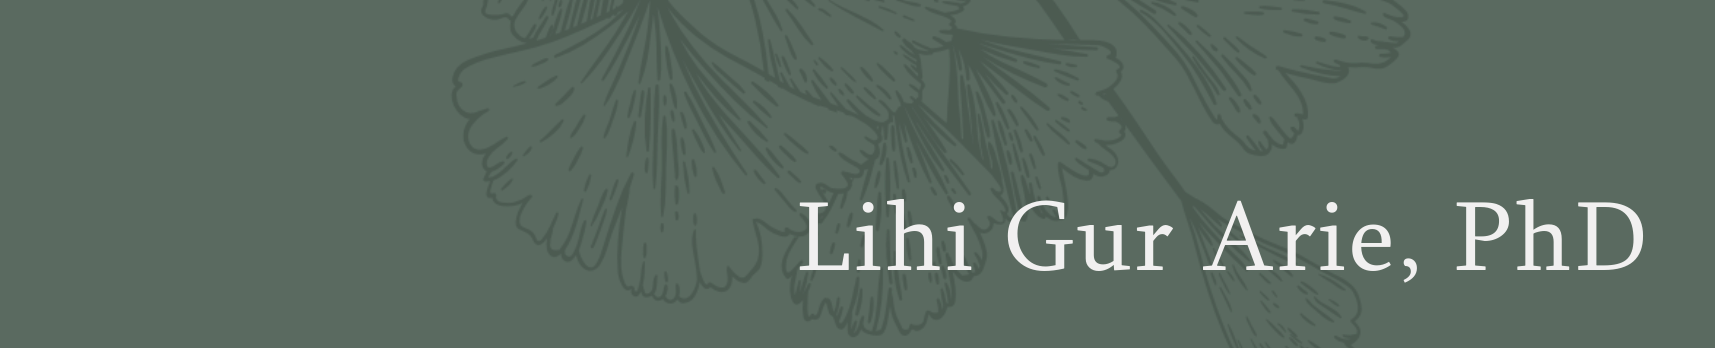

#<font color=40534C size="7.5">**Extracting Structured Vehicle Data from Images**</font>

### <font color=40534C>Build an Automated Vehicle Documentation System that Extracts Structured Information from Images, using OpenAI API, LangChain and Pydantic.</font>

<font color=40534C>This notebook is part of the **"Extracting Vehicle Structured Date from Images"**  tutorial by  **Dr. Lihi Gur Arie**.
For the full tutorial please visit [here](https://medium.com/@lihigurarie/794128aa8696?source=friends_link&sk=a6e9062d3b11be6b3d39b090cd8dec93)<font>

##<font color=40534C>**Setup**</font>

<font color=40534C>**1. OpenAI API Token**: Generate an API token [here](https://platform.openai.com/docs/quickstart)

<font color=40534C>**2. Configure your OpenAI API Token**:
<font color=40534C>Create a new secret with the name OPENAI_API_KEY, paste your token key into the Value input box of OPENAI_API_KEY (🔑), and Toggle the Notebook access on.

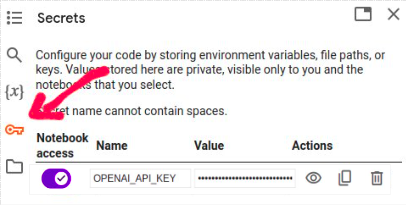

###<font color=40534C>**Install & Import Requirements**</font>

In [ ]:
!pip install langchain_openai

from typing import Any
import os
import glob
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
from IPython.display import Image, display, HTML
import pandas as pd
from google.colab import userdata
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException
from langchain_core.runnables import chain

# Set the OpenAI API key from user data:
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.2/412.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.29
    Uninstalling langchain-core-0.3.29:
      Successfully uninstalled langchain-core-0.3.29


/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


##<font color=40534C>**Dataset Overview**</font>

<font color=40534C>The photos in this tutorial are a sample of 6 vehicle images from the ['Car Number plate'](https://www.kaggle.com/datasets/alihassanml/car-number-plate) Kaggle dataset.

<font color=40534C>The dataset is available under the ['Apache 2.0 License'](https://www.apache.org/licenses/LICENSE-2.0).



In [ ]:
# Get the Vehicle images:
!wget -q "https://drive.usercontent.google.com/download?id=1DtLuSPNR_D9eUD1YEO8ZgjJYV8rWjwLl&export=download&authuser=0&confirm=t&uuid=9899a54b-2a8e-4d75-a5f6-80bd0be178b3&at=AIrpjvNAzJqIkTyvd171DaYO5_W8:1737638733162" -O images.zip
!unzip "/content/images.zip"

# Get images paths:
img_path = "/content/images/N201.jpeg"
img_dir = "/content/images"

# Collect image paths from the directory:
image_paths = glob.glob(os.path.join(img_dir, "*.jpeg"))


Archive:  /content/images.zip
  inflating: images/N201.jpeg        
  inflating: images/N241.jpeg        
  inflating: images/Apache2.0_License.txt  
  inflating: images/N116.jpeg        
  inflating: images/N202.jpeg        
  inflating: images/N38.jpeg         
  inflating: images/N107.jpeg        


<font color=40534C>View the images using the 'display_image_grid' auxiliary function:

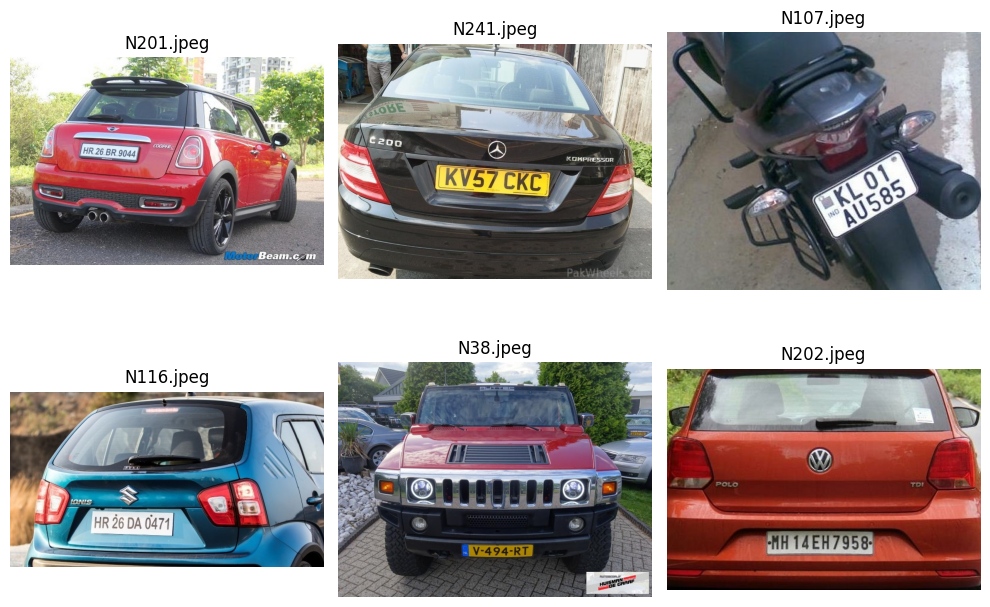

In [ ]:
def display_image_grid(image_paths, rows=2, cols=3, figsize=(10, 7)):
    """
    Display images in a grid layout
    """
    fig = plt.figure(figsize=figsize)
    max_images = rows * cols
    image_paths = image_paths[:max_images]

    for idx, path in enumerate(image_paths):
        ax = fig.add_subplot(rows, cols, idx + 1)
        img = mpimg.imread(path)
        ax.imshow(img)
        ax.axis('off')
        filename = path.split('/')[-1]
        ax.set_title(filename)

    plt.tight_layout()
    plt.show()

display_image_grid(image_paths)

##<font color=40534C>**Pipeline Architecture**</font>

####<font color=40534C>**Image Loading Component**</font>

In [ ]:
def image_encoding(inputs):
    """Load and convert image to base64 encoding"""

    with open(inputs["image_path"], "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    return {"image": image_base64}

####<font color=40534C>**Define the output structure with Pydantic**</font>

In [ ]:
class Vehicle(BaseModel):

    Type: str = Field(
        ...,
        examples=["Car", "Truck", "Motorcycle", 'Bus', 'Van'],
        description="The type of the vehicle.",
    )

    License: str = Field(
        ...,
        description="The license plate number of the vehicle. A continuous sequence of characters without dots, dashes, or spaces.",
    )

    Make: str = Field(
        ...,
        examples=["Toyota", "Honda", "Ford", "Suzuki"],
        description="The Make of the vehicle.",
    )

    Model: str = Field(
        ...,
        examples=["Corolla", "Civic", "F-150"],
        description="The Model of the vehicle.",
    )

    Color: str = Field(
        ...,
        example=["Red", "Blue", "Black", "White"],
        description="Return the color of the vehicle.",
    )

####<font color=40534C>**Parser Component**</font>

In [ ]:
parser = JsonOutputParser(pydantic_object = Vehicle)
instructions = parser.get_format_instructions()
instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Type": {"title": "Type", "description": "The type of the vehicle.", "examples": ["Car", "Truck", "Motorcycle", "Bus", "Van"], "type": "string"}, "License": {"title": "License", "description": "The license plate number of the vehicle. A continuous sequence of characters without dots, dashes, or spaces.", "type": "string"}, "Make": {"title": "Make", "description": "The Make of the vehicle.", "examples": ["Toyota", "Honda", "Ford", "Suzuki"], "type": "string"}, "Model": {"title": "Model", "description": "The Model of the 

####<font color=40534C>**Prompt Generation component**</font>

In [ ]:
@chain
def prompt (inputs):
    """Create the prompt"""

    prompt = [
    SystemMessage(content="""You are an AI assistant whose job is to inspect an image and provide the desired information from the image. If the desired field is not clear or not well detected, return None for this field. Do not try to guess."""),
    HumanMessage(
        content=[
            {"type": "text", "text": """Examine the main vehicle type, license plate number, make, model and color."""},
            {"type": "text", "text": instructions},
            {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{inputs['image']}", "detail": "low", }}]
        )
    ]
    return prompt

####<font color=40534C>**Multimodal LLM Component**</font>

In [ ]:
@chain
def MLLM_response(inputs):
    """Invoke GPT model to extract information from the image"""

    model: ChatOpenAI = ChatOpenAI(
        model="gpt-4o-2024-08-06",
        temperature=0.0,
        max_tokens=1024,
    )
    output = model.invoke(inputs)
    return output.content

####<font color=40534C>**Constructing the pipeline Chain**</font>

In [ ]:
pipeline = image_encoding | prompt | MLLM_response | parser

##<font color=40534C>**Inference**</font>


####<font color=40534C>**Inference on a Single Image**</font>


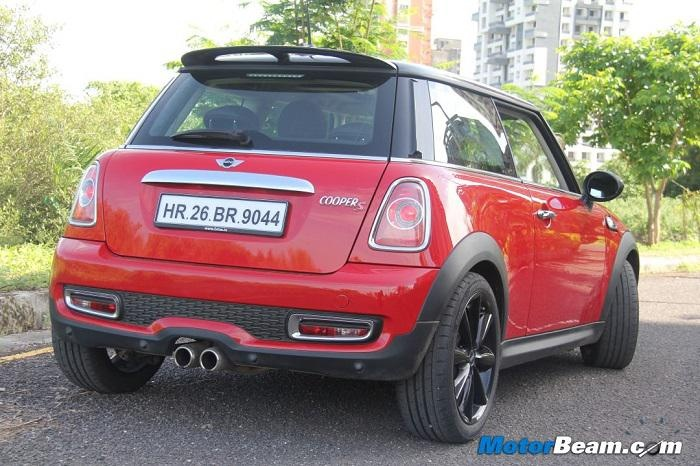

In [ ]:
display(Image(img_path))

In [ ]:
output = pipeline.invoke({"image_path": f"{img_path}"})
output

{'Type': 'Car',
 'License': 'HR26BR9044',
 'Make': 'Mini',
 'Model': 'Cooper',
 'Color': 'Red'}

<font color=40534C>Convert the output dictionary to JSON:

In [ ]:
json_output = json.dumps(output)

####<font color=40534C>**Inference on a Batch of Images**</font>

<font color=40534C>Create a list of dictionaries containing image paths, and invoke batch inference:

In [ ]:
batch_input = [{"image_path": path} for path in image_paths]
output = pipeline.batch(batch_input)

<font color=40534C>Converte the output to a DataFrame:

In [ ]:
df = pd.DataFrame(output)
files_list = ([os.path.basename(path) for path in image_paths])
df.index = files_list
df

,Type,License,Make,Model,Color
N201.jpeg,Car,HR26BR9044,Mini,Cooper,Red
N241.jpeg,Car,KV57CKC,Mercedes,C200,Black
N107.jpeg,Motorcycle,KL01AU585,None,None,Black
N116.jpeg,Car,HR26DA0471,Suzuki,Ignis,Blue
N38.jpeg,Car,V494RT,Hummer,H2,Red
N202.jpeg,Car,MH14EH7958,Volkswagen,Polo,Orange


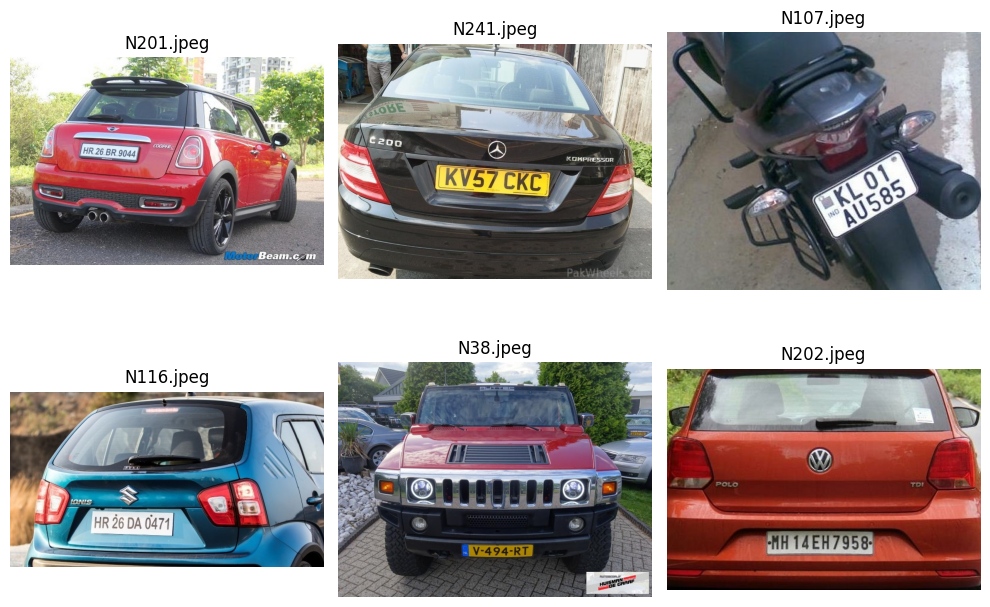

In [ ]:
display_image_grid(image_paths)

# <font color=40534C size="6.5">**The End!**</font>
<font color=40534C>For more content of mine, please visit  [Here](https://medium.com/@lihigurarie)</font>

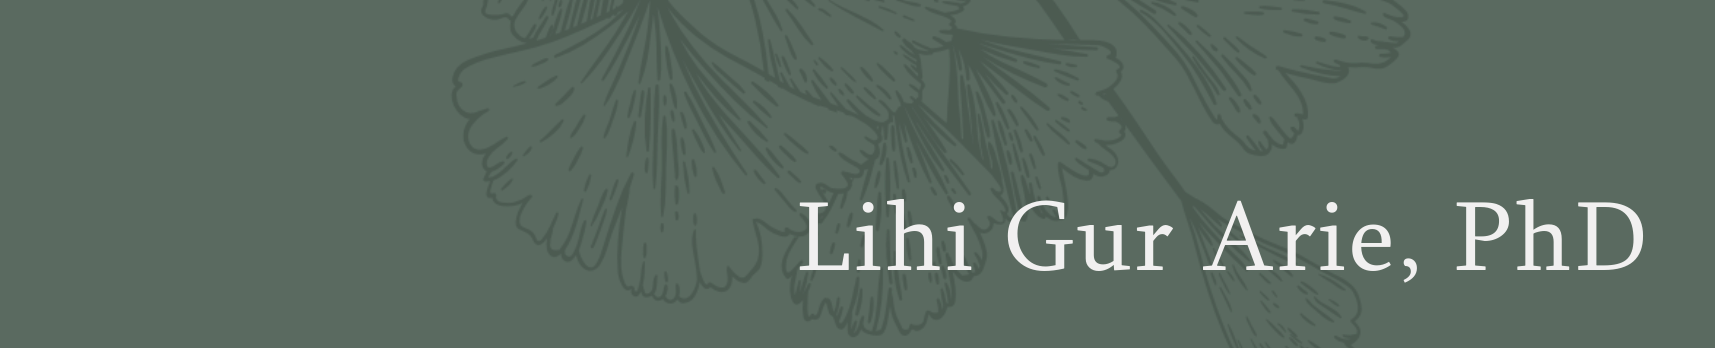